In [1]:
import numpy as np
import copy
import os
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader

#device
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print()

#version
print("PyTorch version: {}  Torchvision version: {}".format(torch.__version__, torchvision.__version__))


cpu

PyTorch version: 1.8.1+cpu  Torchvision version: 0.9.1+cpu


In [2]:
#load data
data_dir="/home/isack/Desktop/isack/Diabetic Retnopathy/Disease Grading/Original Images/"

input_size=224

#transform my data
data_transform={
    "train":transforms.Compose([
          transforms.ToTensor(), 
          transforms.RandomResizedCrop(input_size),
          transforms.RandomHorizontalFlip(), 
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val":transforms.Compose([
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(), 
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

datasets={x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform=data_transform[x]) for x in ["train", "val"]}

#make my data iteratible
shuffle=True
dataloader_dict={x: DataLoader(datasets[x], shuffle=shuffle, batch_size=4, num_workers=3) for x in ["train", "val"]}

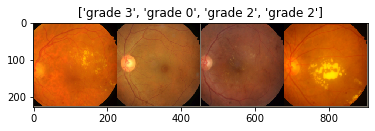

In [3]:
#looking my data
def show(img, title=None):
    np_img=img.numpy().transpose(1, 2, 0)
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    imgs=np_img*std + mean
    imgs=np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.title(title)

i, o= next(iter(dataloader_dict["val"]))
imgs=torchvision.utils.make_grid(i)

class_name=datasets["val"].classes
show(imgs, title=[class_name[x] for x in o])

In [4]:
#load my model
model_ft=models.resnet101(pretrained=True)

#freeze all parameters
for params in model_ft.parameters():
    params.requires_grad=False
    
"""#handle the auxiliary net
num_ftrs=model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc=nn.Linear(num_ftrs, 5)"""

#handle the primary net
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs, 5)

#create my optimizer
params_to_update=model_ft.parameters()

for names, params in model_ft.named_parameters():
    if params.requires_grad==True:
       # params_to_update.append(params)
        print("\t",names)
        
optimizer_ft=optim.SGD(params_to_update, lr=0.001, momentum=0.9)

scheduler_ft=lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

#create my criterion
criterion_ft=nn.CrossEntropyLoss()

	 fc.weight
	 fc.bias


In [5]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
def train_model(model, criterion, scheduler, optimizer, dataloader, num_epoch, is_inception=False):
    
    since=time.time()
    best_model=copy.deepcopy(model.state_dict())
    best_acc=0.0
    val_acc_hist, val_loss_hist=[], []
    trn_acc_hist, trn_loss_hist=[],[]
    
    for epoch in range(num_epoch):
        print("{}/{}".format(epoch, num_epoch-1))
        print(" - - "*10)
        
        #every epoch have training and validation
        for phase in ["train", "val"]:
            
            if phase=="train":
                model.train()
                
            else:
                model.eval()
                
            running_loss=0.0
            running_acc=0
            
            #iterate over datasets
            for inputs, labels in (dataloader[phase]):
                inputs=Variable(inputs)
                labels=Variable(labels)
                
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                #zero parameters
                optimizer.zero_grad()
                
                #forward
                #track the history
                with torch.set_grad_enabled(phase=="train"):
                    
                    if is_inception and phase=="train":
                        
                        outputs, aux_outputs=model(inputs)
                        loss1=criterion(outputs, labels)
                        loss2=criterion(aux_outputs, labels)
                        loss=loss1 + loss2*0.4
                        
                    else:
                        outputs=model(inputs)
                        loss=criterion(outputs, labels)
                        
                    _,pred=torch.max(outputs, 1)
                      
                    #backwards
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                    
                #statistics
                running_loss += loss.item()*inputs.size(0)
                running_acc += torch.sum(pred==labels.data).item()
                    
            if phase=="val":
                scheduler.step()
                
            epoch_loss=running_loss/len(dataloader[phase].dataset)
            epoch_acc=running_acc/len(dataloader[phase].dataset)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase=="val" and epoch_acc > best_acc:
                best_acc=epoch_acc
                best_model=copy.deepcopy(model.state_dict())
                
            if phase == "val":
                val_acc_hist.append(epoch_acc)
                val_loss_hist.append(epoch_loss)
                
            else:
                trn_acc_hist.append(epoch_acc)
                trn_loss_hist.append(epoch_loss)
                
            acc_loss_hist={
                "val_acc_hist":val_acc_hist,
                "val_loss_hist":val_loss_hist,
                "trn_acc_hist":trn_acc_hist,
                "trn_loss_hist":trn_loss_hist
            }
                
        print()   
        
    time_elipsed=time.time() - since
        
    print("Training complete in {:.0f}m  and  {:.0f}s".format(time_elipsed//60 , time_elipsed%60))
        
    print("Best val acc: {:.4f}".format(best_acc))
        
    #load the best model
    model.load_state_dict(best_model)
    return acc_loss_hist , model

In [7]:
model_name="resnet101"
acc_loss_hist , model=train_model(model_ft, criterion_ft, scheduler_ft, optimizer_ft, dataloader_dict, num_epoch=24, is_inception=(model_name=="inception"))

0/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.5066 Acc: 0.3535
val Loss: 1.7822 Acc: 0.3107

1/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.4907 Acc: 0.3826
val Loss: 1.4438 Acc: 0.4854

2/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.5377 Acc: 0.4068
val Loss: 1.6074 Acc: 0.4563

3/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.2031 Acc: 0.5157
val Loss: 1.3694 Acc: 0.4757

4/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.1553 Acc: 0.5278
val Loss: 1.4568 Acc: 0.4466

5/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.1485 Acc: 0.5036
val Loss: 1.6128 Acc: 0.4563

6/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.0938 Acc: 0.5569
val Loss: 1.4657 Acc: 0.4660

7/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Loss: 1.1343 Acc: 0.5617
val Loss: 1.3396 Acc: 0.4563

8/23
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
train Lo

In [8]:
path1="/home/isack/Desktop/isack/Diabetic Retnopathy/saved_models/model_resnet101.pth"
path2="/home/isack/Desktop/isack/Diabetic Retnopathy/saved_models/model_wight_resnet101.pth"
path3="/home/isack/Desktop/isack/Diabetic Retnopathy/saved_models/acc_loss_hist_resnet101.pth"
model_inception_v3=torch.save(model,path1)
model_wight_inception_v3=torch.save(model.state_dict(), path2)
acc_loss_hist_inception_v3=torch.save(acc_loss_hist, path3)

In [9]:
acc_loss_hist=torch.load(path3)

Text(0.5, 1.0, 'TRAINING & VALIDATION ACCURACY')

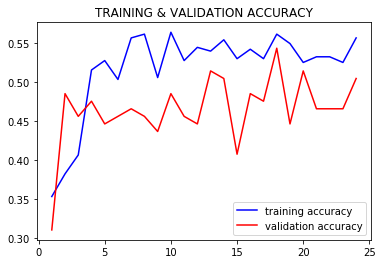

In [10]:
plt.plot(range(1, len(acc_loss_hist["trn_acc_hist"])+1), acc_loss_hist["trn_acc_hist"], 'b', label='training accuracy')

plt.plot(range(1, len(acc_loss_hist["val_acc_hist"])+1), acc_loss_hist["val_acc_hist"], 'r', label='validation accuracy')

plt.legend()
plt.title("TRAINING & VALIDATION ACCURACY")

Text(0.5, 1.0, 'TRAINING & VALIDATION LOSSES')

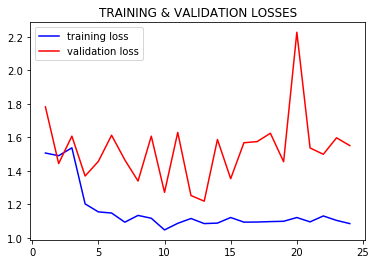

In [11]:
plt.plot(range(1, len(acc_loss_hist["trn_loss_hist"])+1), acc_loss_hist["trn_loss_hist"], 'b', label='training loss')

plt.plot(range(1, len(acc_loss_hist["val_loss_hist"])+1), acc_loss_hist["val_loss_hist"], 'r', label='validation loss')

plt.legend()
plt.title("TRAINING & VALIDATION LOSSES")